In [1]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report as report

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import tensorflow as tf

/Users/minkim/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/minkim/anaconda3/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/minkim/anaconda3/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference

# 1. 데이터 확인

In [2]:
df = pd.read_csv('./telecom_customer_churn.csv', encoding='euc-kr')

#### 데이터 파악

In [3]:
# df.profile_report()

# 2. 데이터 전처리

#### Columns Prep

In [4]:
# rename cols for our convenience
df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

In [5]:
df.columns

Index(['customer_id', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zip_code', 'latitude', 'longitude', 'number_of_referrals',
       'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'churn_category', 'churn_reason'],
      dtype='object')

In [6]:
# drop no need cols
df = df.drop(['city', 'zip_code', 'latitude', 'longitude'], axis = 1)

In [7]:
# create tenure_in_years col
df['tenure_in_years'] = 0
df.loc[(df['tenure_in_months'] <= 12), 'tenure_in_years'] = '1'
df.loc[(df['tenure_in_months'] > 12) & (df['tenure_in_months']  <= 24), 'tenure_in_years'] = '2'
df.loc[(df['tenure_in_months'] > 24) & (df['tenure_in_months'] <= 36), 'tenure_in_years'] = '3'
df.loc[(df['tenure_in_months'] > 36) & (df['tenure_in_months'] <= 48), 'tenure_in_years'] = '4'
df.loc[(df['tenure_in_months'] > 48) & (df['tenure_in_months'] <= 60), 'tenure_in_years'] = '5'
df.loc[df['tenure_in_months'] > 60, 'tenure_in_years'] = '6'
df = df.astype({'tenure_in_years': 'int'})
df['tenure_in_years'].value_counts()

1    2186
6    1407
2    1024
5     832
3     832
4     762
Name: tenure_in_years, dtype: int64

#### 'churn' col (binary variables)

In [8]:
# drop 'joined' customer to avoid prediction bias
# df = df[df["customer_status"] != "Joined"]

# create 'churn' col
df['churn'] = np.where(df['customer_status'] == 'Churned', 'Yes', 'No')

- If customer status is *'churned'* then ***'yes'***, else, in case of 'joined' and 'stayed', ***"No"***

## 2-1. 중복값

In [9]:
print(df.duplicated('customer_id', keep=False).sum())

0


- **Check for the absence of Duplicate Values on 'customer_id'**

## 2-2.결측치

#### check for missing values

In [10]:
# df.isnull().sum()
df.isnull().sum().to_frame('nan_count')

,nan_count
customer_id,0
gender,0
age,0
married,0
number_of_dependents,0
number_of_referrals,0
tenure_in_months,0
offer,0
phone_service,0
avg_monthly_long_distance_charges,682


- **A great number of Null-values: Churn Category, Churn Reason**

#### Nulls of features that are related to 'Phone Service'

In [11]:
df['avg_monthly_long_distance_charges'] = df['avg_monthly_long_distance_charges'].fillna(df['avg_monthly_long_distance_charges'].mean())

In [12]:
df.multiple_lines = df.multiple_lines.fillna('No Phone Service')

- **Features that are correlated with 'Phone Service': 'Avg Monthly Long Distance Charges' and 'Multiple Lines'**
- **As customers who do not use the *Phone Service* miss the values of the phone service-related columns, the mean value of 'Avg Monthly Long Distance Charges' and the string 'No Phone Service' are filled in them.**

#### Nulls of features that are related to 'Internet Service'

In [13]:
no_internet_service = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan','premium_tech_support',
                       'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet_service] = df[no_internet_service].fillna('No Internet Service')

In [14]:
df['avg_monthly_gb_download'] = df['avg_monthly_gb_download'].fillna(df['avg_monthly_gb_download'].mean())

- **Features that are correlated with 'Internet Service' = list of *no_internet_service*.**
- **Internet Service-related columns are filled as either mean value or string 'No internet service'.**

#### Nulls of object columns to 'None'

- **Missing values of 'Churn Category' and 'Churn Reason' are filled as *None* as their datatype is object.**
- 일단 생략하는 이유: 이후 churning reasons 뽑을 때 분석 방해

# 3. 데이터 시각화 / EDA

In [15]:
palette = sns.color_palette('Set3')

#### changes in monthly_charge following other IVs

<AxesSubplot: xlabel='tenure_in_months', ylabel='monthly_charge'>

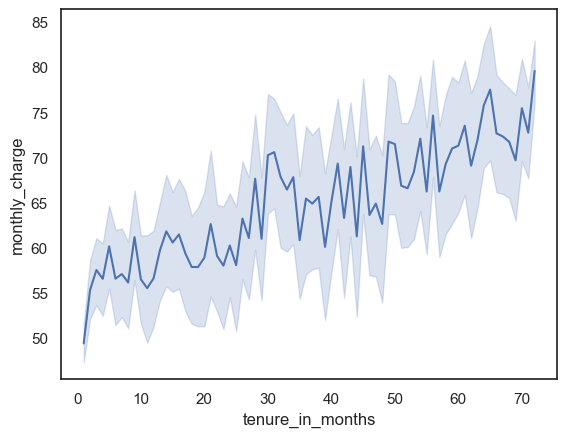

In [16]:
sns.lineplot(data = df, x='tenure_in_months', y='monthly_charge')

계약 유지 기간이 길면 월별 금액이 높은 것을 알 수 있음

#### changes in monthly_charge (group by 'customer')

In [17]:
df.groupby('churn')['monthly_charge'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,5174.0,60.073618,32.056245,-10.0,24.8,63.2,87.5,118.75
Yes,1869.0,73.347592,26.373764,-10.0,55.3,79.5,94.2,118.35


In [18]:
df.groupby(['churn', 'gender'])['monthly_charge'].describe()

count       mean        std   min     25%   50%     75%     max
churn gender                                                                  
No    Female  2549.0  60.773696  31.912681 -10.0  25.000  64.0  88.400  118.75
      Male    2625.0  59.393810  32.186544 -10.0  24.600  62.1  86.750  118.20
Yes   Female   939.0  73.606656  26.093400 -10.0  59.625  79.5  93.625  117.45
      Male     930.0  73.086022  26.665339  -9.0  53.875  79.5  94.500  118.35

In [19]:
df.groupby('churn')['total_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,5174.0,2550.792103,2329.091754,18.80,574.3875,1679.525,4262.85,8672.45
Yes,1869.0,1531.796094,1890.822994,18.85,134.5000,703.550,2331.30,8684.80


<AxesSubplot: xlabel='tenure_in_months', ylabel='total_revenue'>

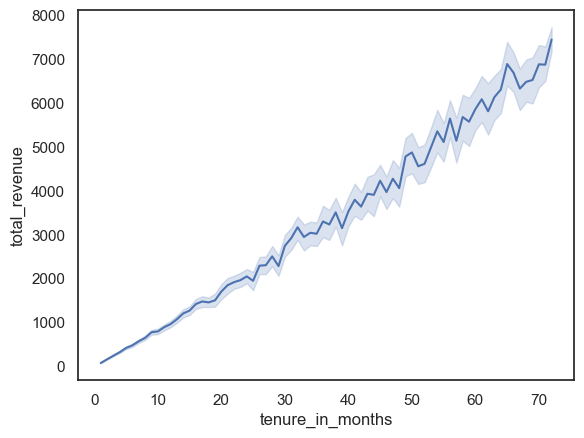

In [20]:
sns.lineplot(data = df, x='tenure_in_months', y='total_revenue')

#### exclude (zip_code, latitude, longitude ...)

In [21]:
# df.groupby('zip_code')['total_long_distance_charges'].describe()

In [22]:
# sns.scatterplot(data = df, x='longitude', y='latitude', hue='churn', palette = 'Set3')

지역별로 보았을 때 한 곳에 이탈 고객이 몰려있거나 하는 특징이 없음을 알 수 있음

zip code, latitude, longitude, city 컬럼 제외

#### Check for the churning reasons

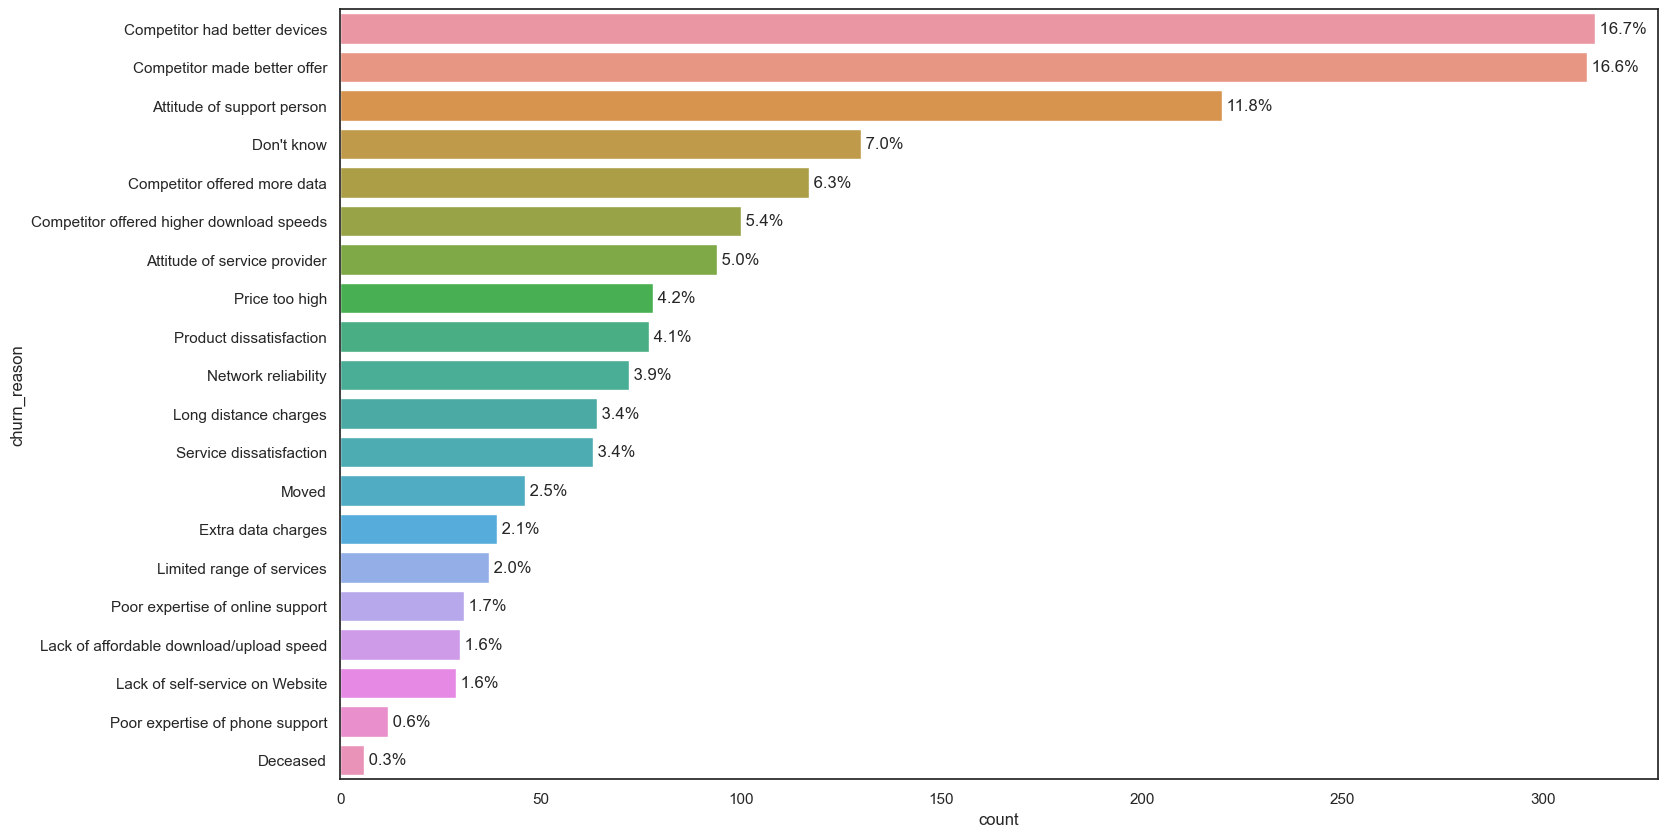

In [23]:
# sns.countplot(data = df, y = 'churn_reason', order = df['churn_reason'].value_counts().index)
# order 사용하여 내림차순으로 정렬


import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,10))
churn_reason = df['churn_reason'].dropna()
sns.countplot(data=df, y=churn_reason, ax=ax, order=df['churn_reason'].value_counts().index)
total = len(churn_reason)
for p in ax.patches: # ax.patches : 그래프 위에 비율 쓰고 싶을 때 사용하는 메소드
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(' '+percentage, (x,y), ha='left', va='center', fontsize=12)
plt.show()
# good

age                                     AxesSubplot(0.125,0.786098;0.133621x0.0939024)
number_of_dependents                 AxesSubplot(0.285345,0.786098;0.133621x0.0939024)
number_of_referrals                   AxesSubplot(0.44569,0.786098;0.133621x0.0939024)
tenure_in_months                     AxesSubplot(0.606034,0.786098;0.133621x0.0939024)
avg_monthly_long_distance_charges    AxesSubplot(0.766379,0.786098;0.133621x0.0939024)
avg_monthly_gb_download                 AxesSubplot(0.125,0.673415;0.133621x0.0939024)
monthly_charge                       AxesSubplot(0.285345,0.673415;0.133621x0.0939024)
total_charges                         AxesSubplot(0.44569,0.673415;0.133621x0.0939024)
total_refunds                        AxesSubplot(0.606034,0.673415;0.133621x0.0939024)
total_extra_data_charges             AxesSubplot(0.766379,0.673415;0.133621x0.0939024)
total_long_distance_charges             AxesSubplot(0.125,0.560732;0.133621x0.0939024)
total_revenue                        AxesSu

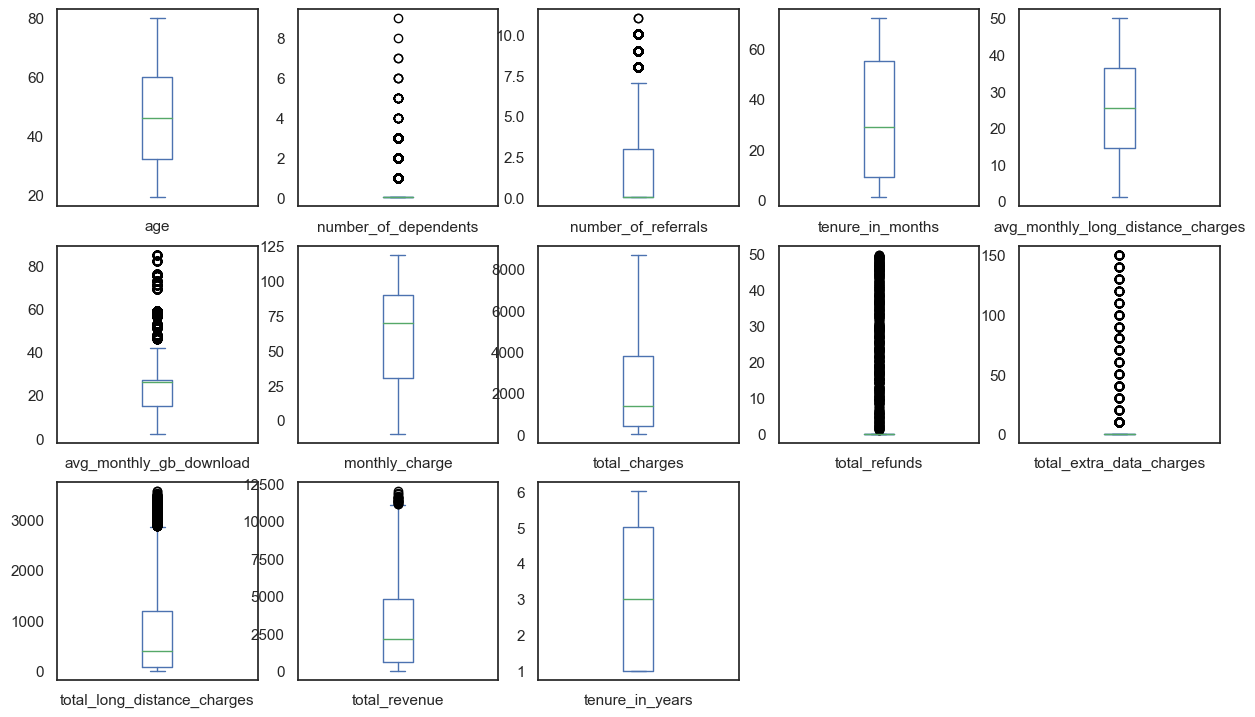

In [24]:
df.plot(kind='box', subplots=True, layout=(7, 5), figsize=(15, 21))
# 수치형 컬럼에 대한 이상치 확인?

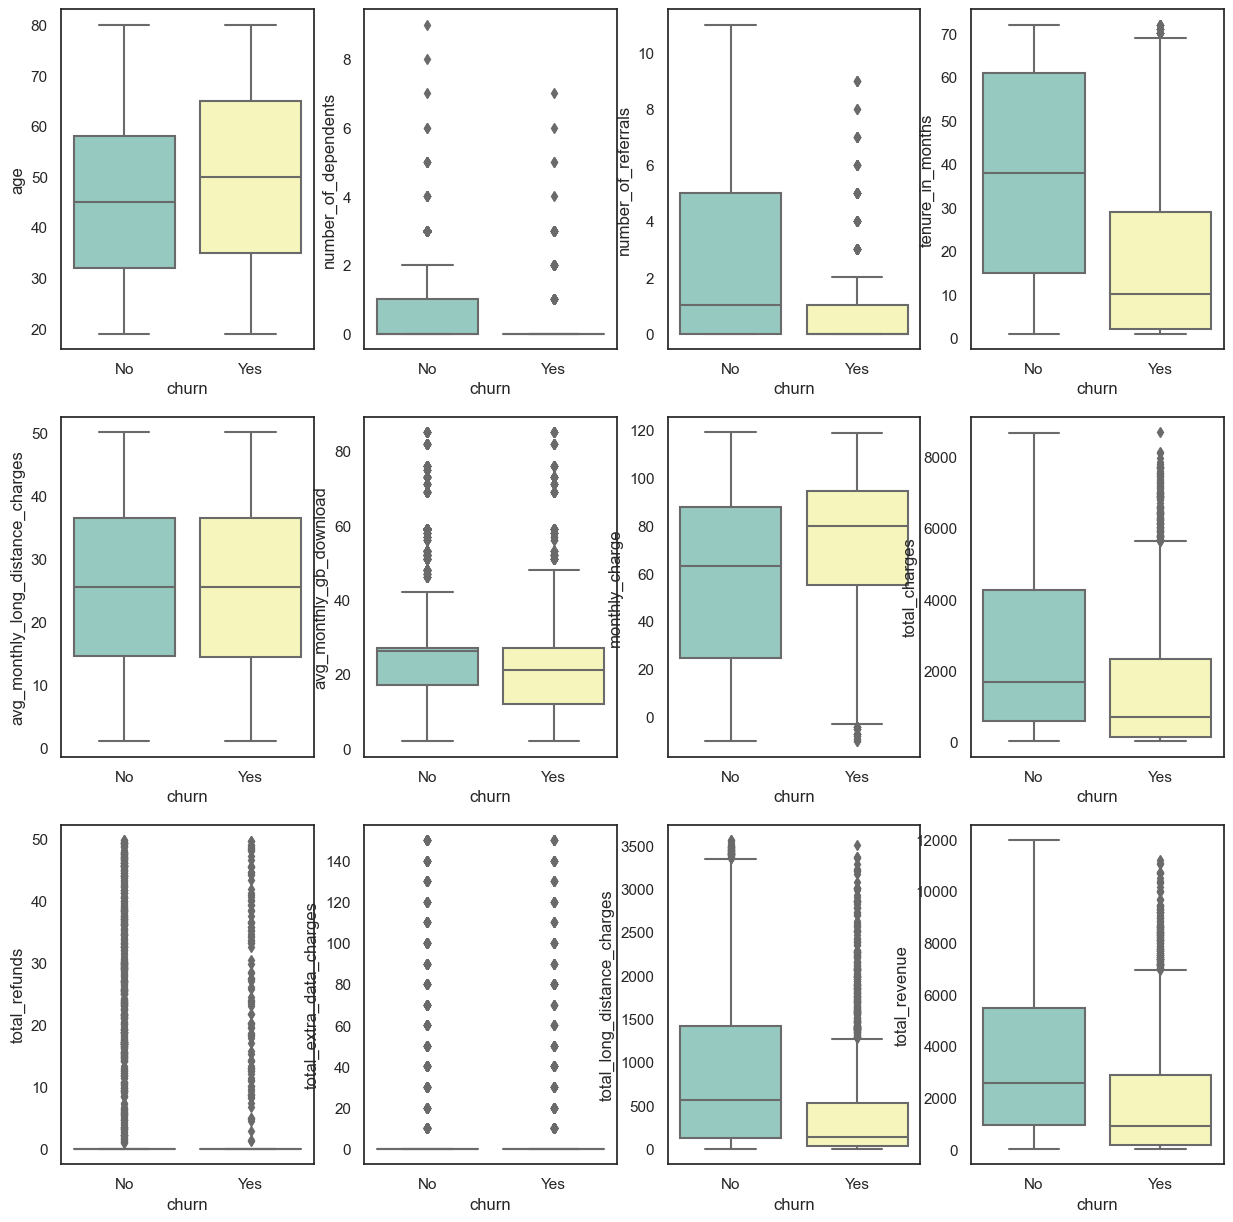

In [25]:
number_col = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
              'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges',
              'total_long_distance_charges', 'total_revenue']
fig, ax = plt.subplots(3,4, figsize = (15,15))
for i, subplot in zip(number_col, ax.flatten()):
    sns.boxplot(x = 'churn', y = i , data = df, ax = subplot, palette = 'Set3')

- **number of dependents**: 대부분의 고객은 부양가족이 없습니다.

- **monthly charge**: 이탈 고객의 월간 요금 중앙값이 충성고객의 월간 요금 중앙값보다 높다는 것을 알 수 있습니다. 요금이 너무 높으면 고객이 이탈할 가능성이 더 높다고 생각할 수 있습니다.
    - feedback: 높은 요금을 쓰는 메리트가 없어, 높은 요금을 쓰는 사람의 탈퇴비율 up


In [26]:
#plt.figure(figsize=(25,25))

#for i, col in enumerate(number_col):
#    ax = plt.subplot(5, 5, i+1)
#    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set3')
#    ax.set_title(f"{col}")

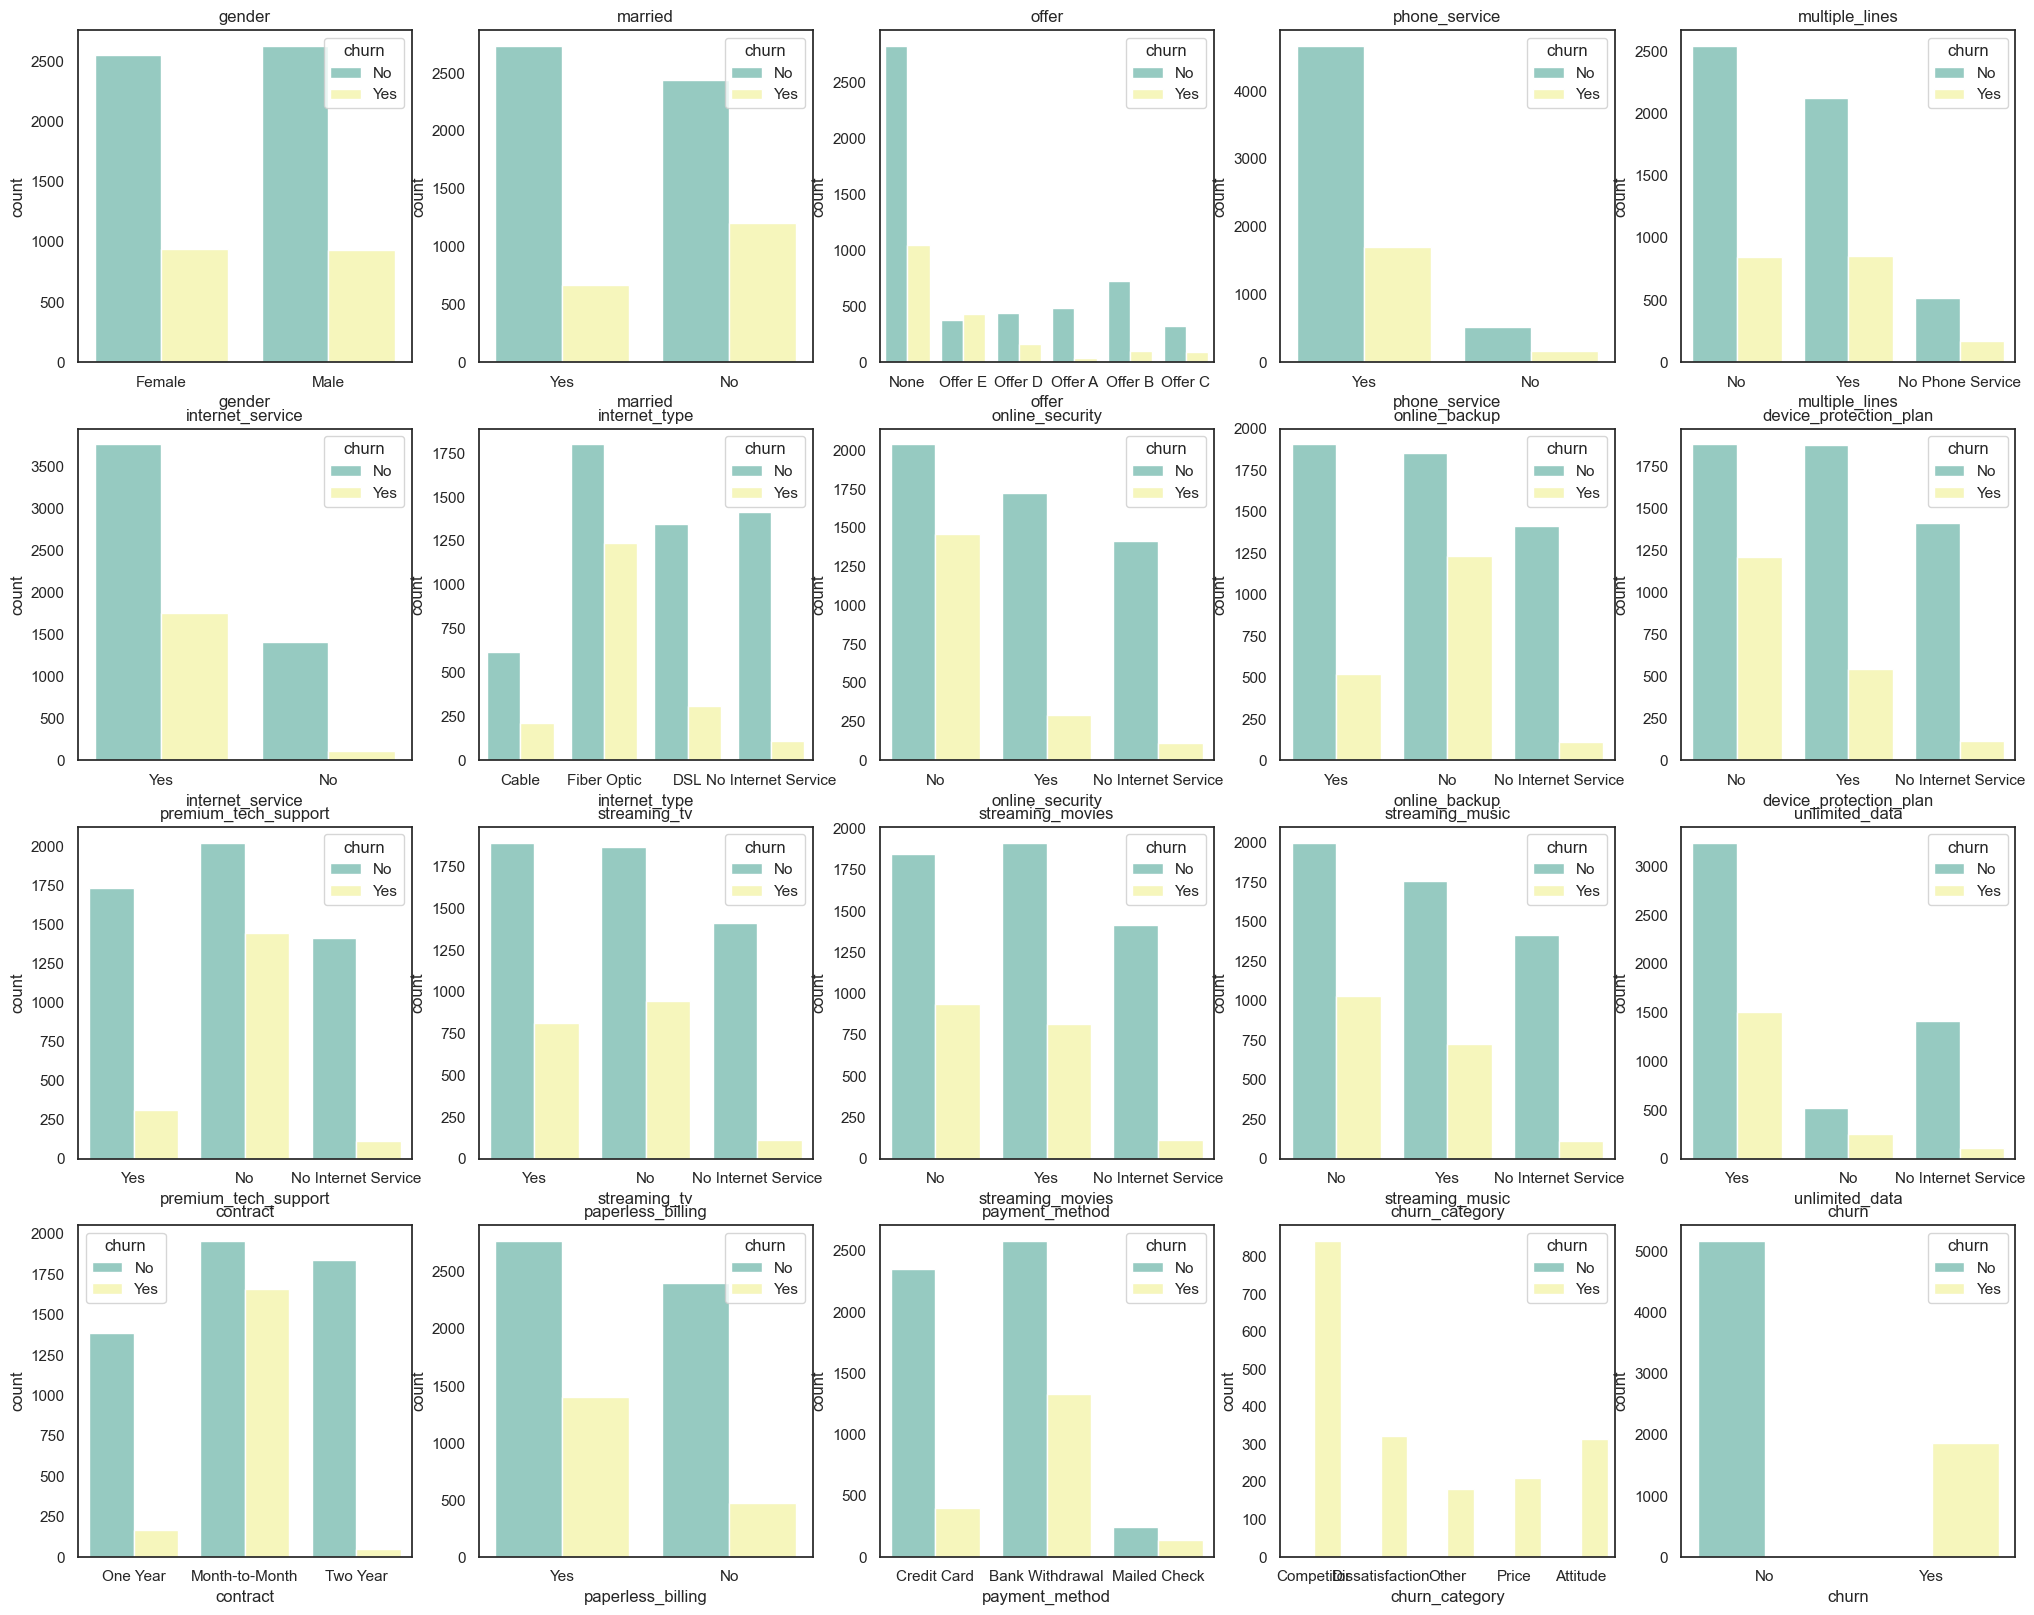

In [27]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']
plt.figure(figsize=(25,25))

for i, col in enumerate(object_col):
    ax = plt.subplot(5, 5, i+1)
    sns.countplot(x =str(col), hue = 'churn', data = df, palette = 'Set3')
    ax.set_title(f"{col}")

- **offer**: 대부분의 고객은 마케팅 제안을 수락하지 않았습니다. 기업은 낮은 마케팅율을 개선하기를 바랄 수 있습니다. 마케팅 제안 E를 구독한 후 높은 고객 이탈률을 관찰했습니다.

- **multiple lines**: multiple lines는 충성고객과 이탈 고객이 균등하게 분배되어 있으므로 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.

- **internet service**: 인터넷 서비스에 가입하면 이탈율이 높아집니다.
    - 결합해서 쓰는 경우 이탈율 높아짐 34.5%
    - 인터넷 서비스 유저 이탈율 26.4%
    - 폰서비스 유저 이탈율 8.4%

- **internet type**: Fiber > DSL > Cable. 다양한 인터넷 연결 유형 중 Fiber Optic이 가장 널리 사용됩니다. Cable 및 DSL에 비해 가격이 비싸더라도 다운로드 및 업로드 속도가 가장 빠르기 때문입니다.
    - feedback 요금이 비싼 데 비하여, 통신사쪽 메리트가 없음(그래서 이탈율 up).
    - 지훈님: 의사결정트리 (fiber == 1, other == 0).

- **online security, online backup, device protection plan**: 인터넷 부가서비스. 이탈 고객은 이 기능을 구매(선택)할 가능성이 거의 없습니다.

- **premium tech support**: 많은 이탈 고객이 premium tech support를 받지 않았습니다. 기술적 문제가 이탈 결정에 영향을 미칠 수도 있다는 것을 알 수 있습니다.

- **streaming tv, movies, music**: streaming tv, movies, music은 충성고객과 이탈고객의 큰 차이가 없이 균등해 보이므로 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.

- **unlimited data**: 많은 고객에게 무제한 데이터가 인기가 있습니다.

- **contract**: 월 단위로 지불하는 사용자는 이탈할 가능성이 높습니다. 대부분의 충성 고객은 1, 2년 계약입니다.

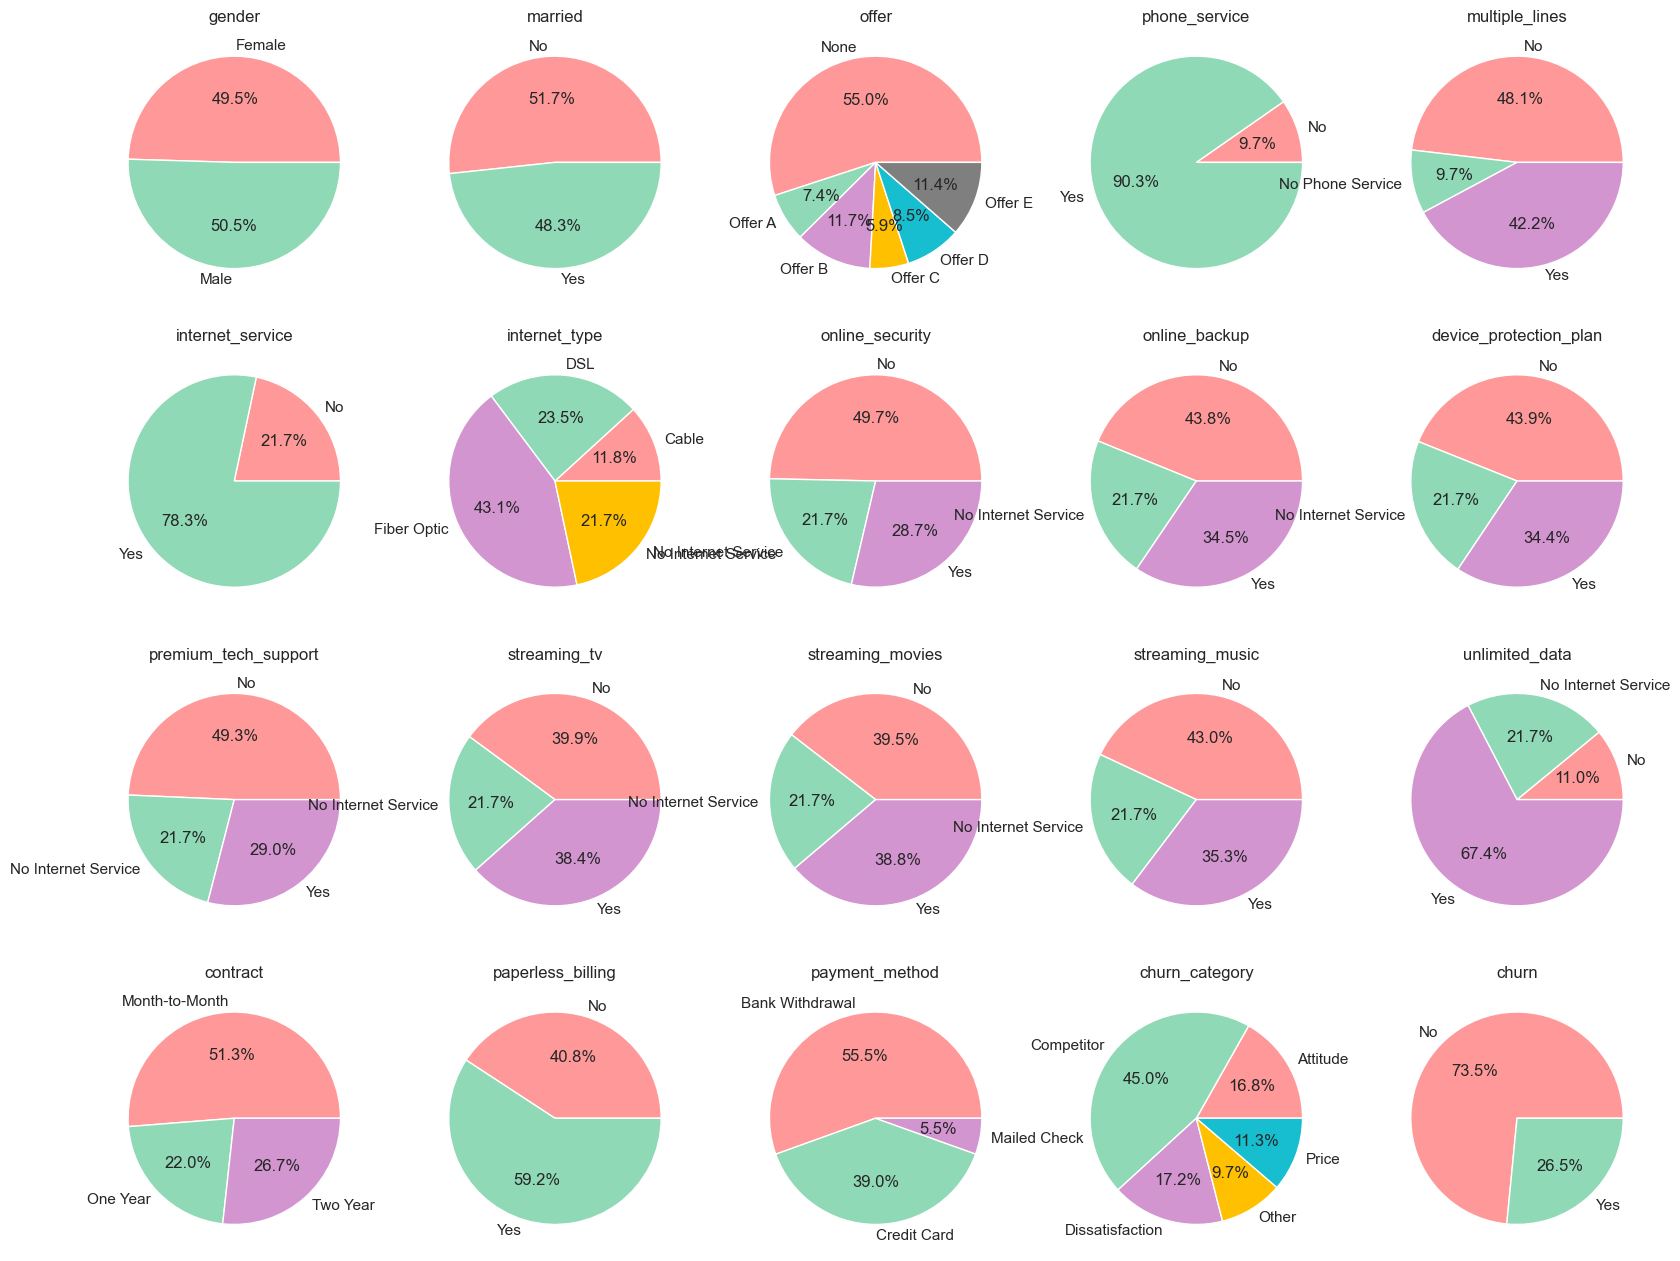

In [28]:
object_col = ['gender', 'married', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type',
              'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv',
              'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method',
              'churn_category', 'churn']
#_ = df[object_col]
colors = ['#ff9999', '#8fd9b6', '#d395d0', '#ffc000', '#17becf', '#7f7f7f']

fig = plt.figure(figsize = (20, 20))
i = 1
for a in df[object_col].columns:
    plt.subplot(5, 5, i)
    ax = df.groupby([a]).size().plot(kind = 'pie', autopct = '%.1f%%', colors = colors)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(a), loc='center')
    i += 1

In [29]:
# 이탈여부 파이차트
# autopct : 부채꼴 안에 표시될 숫자의 형식을 지정
# df['churn'].value_counts().plot(kind='pie', autopct ='%1.1f%%')
# plt.show()

In [30]:
# 컬럼 삭제
# df=df.drop(columns=['customer_id','churn_category','churn_reason','zip_code','longitude','latitude','city'])

# total_refunds...

### 데이터 인코딩

원핫인코딩을 쓰면 좋을지 라벨 인코딩을 쓰면 좋을지

라벨 인코딩으로 결정

데이터 인코딩 후 상관관계 확인, 컬럼 선정하여 훈련세트와 테스트 세트 나눠 모델 학습

In [31]:
# 라벨 인코딩을 적용할 변수의 리스트 : object_col

# fit()과 transform()으로 라벨 인코딩을 수행
for feature in object_col:
    # LabelEncoder를 객체로 생성
    encoder = LabelEncoder()
    # fit, transform 메소드를 통한 레이블 인코딩
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])

In [32]:
df

,customer_id,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,...,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status,churn_category,churn_reason,tenure_in_years,churn
0,0002-ORFBO,0,37,1,0,2,9,0,1,42.390000,...,593.30,0.00,0,381.51,974.81,Stayed,5,NaN,1,0
1,0003-MKNFE,1,46,0,0,0,9,0,1,10.690000,...,542.40,38.33,10,96.21,610.28,Stayed,5,NaN,1,0
2,0004-TLHLJ,1,50,0,0,0,4,5,1,33.650000,...,280.85,0.00,0,134.60,415.45,Churned,1,Competitor had better devices,1,1
3,0011-IGKFF,1,78,1,0,1,13,4,1,27.820000,...,1237.85,0.00,0,361.66,1599.51,Churned,2,Product dissatisfaction,2,1
4,0013-EXCHZ,0,75,1,0,3,3,0,1,7.380000,...,267.40,0.00,0,22.14,289.54,Churned,2,Network reliability,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,0,20,0,0,0,13,4,1,46.680000,...,742.90,0.00,0,606.84,1349.74,Stayed,5,NaN,2,0
7039,9992-RRAMN,1,40,1,0,1,22,4,1,16.200000,...,1873.70,0.00,0,356.40,2230.10,Churned,2,Product dissatisfaction,2,1
7040,9992-UJOEL,1,22,0,0,0,2,5,1,18.620000,...,92.75,0.00,0,37.24,129.99,Joined,5,NaN,1,0
7041,9993-LHIEB,1,21,1,0,5,67,1,1,2.120000,...,4627.65,0.00,0,142.04,4769.69,Stayed,5,NaN,6,0


In [33]:
# Label Encoding 결과 재복원
# print(encoder.inverse_transform(df["married"]))

In [34]:
# 컬럼 삭제
df=df.drop(columns=['customer_id','churn_category','churn_reason', 'total_refunds'])

-feedback
음수로 나오는 상관관계 다시보기

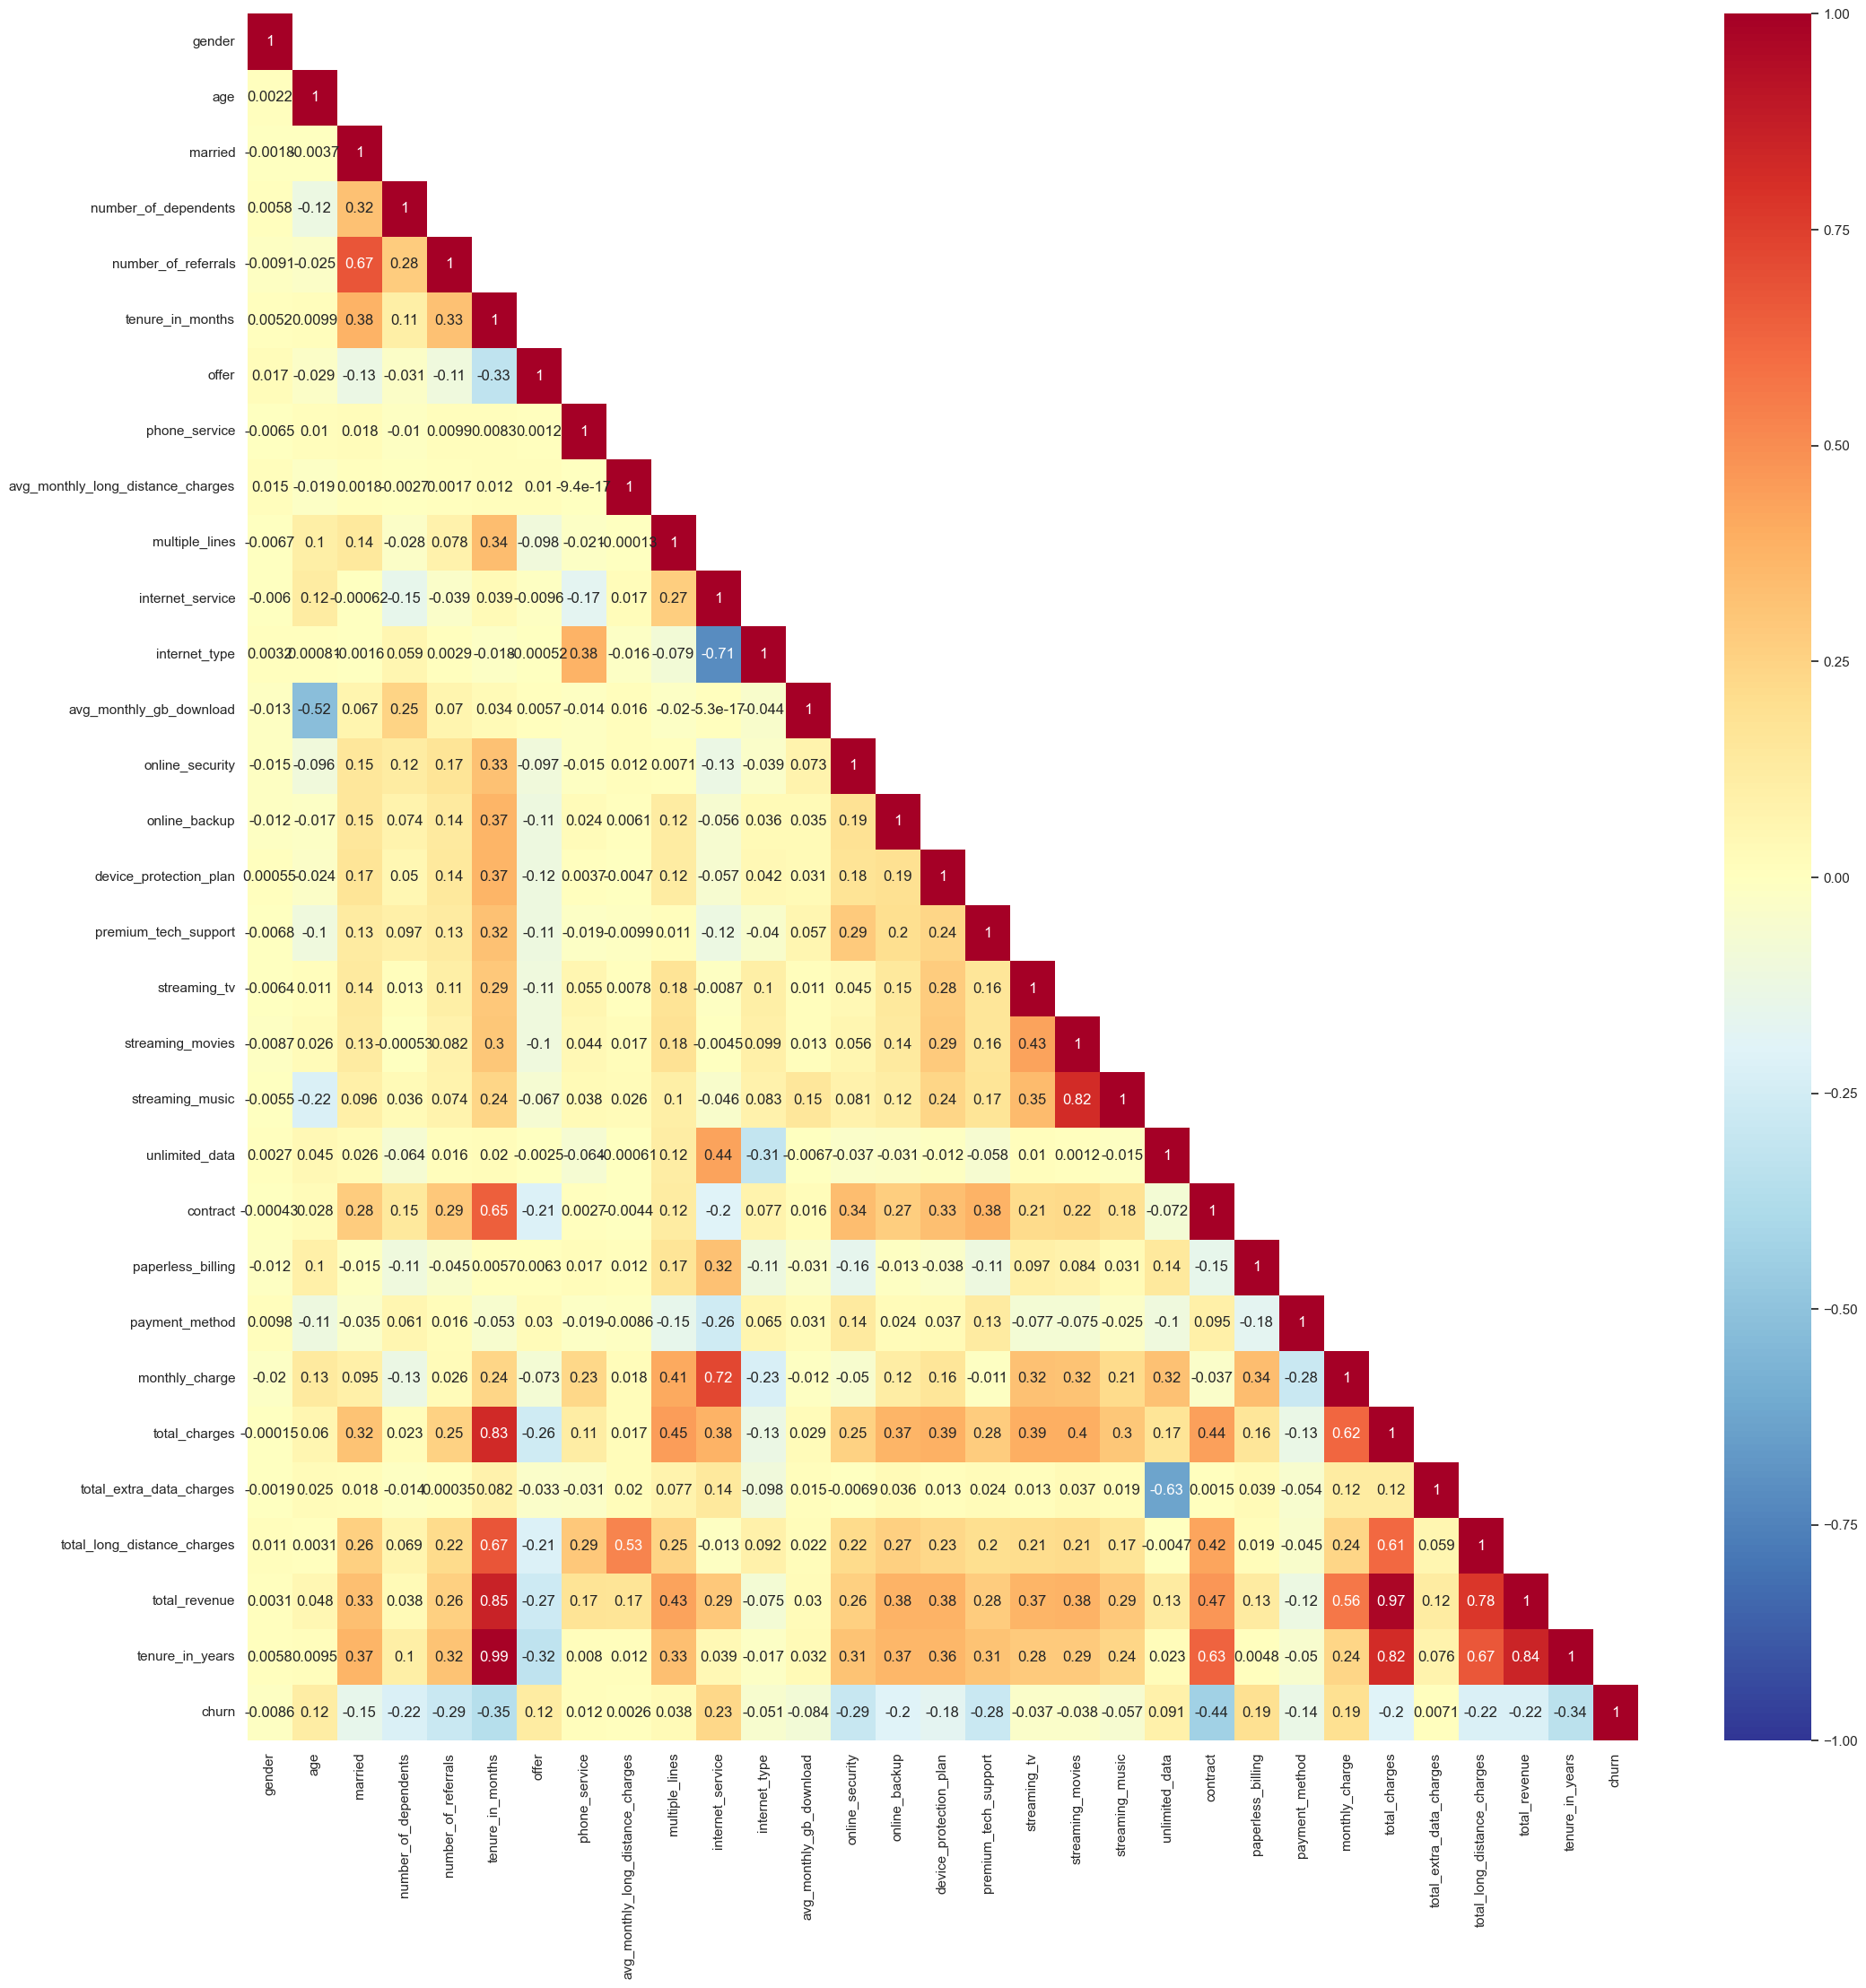

In [35]:
# 상관계수 시각화
raw = df.corr()
plt.figure(figsize = (25,25))
mask = np.array(raw)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(raw,
              annot = True,# 실제 값 화면에 나타내기
              mask = mask,
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
              vmin = -1, vmax = 1, # 컬러차트 -1 ~ 1 범위로 표시
              )
plt.show()

**약한 상관관계**

total_refunds가 모든 컬럼과 상관관계가 약합니다.


**강한 상관관계**

married & number_of_referrals : 0.67

monthly_charge & internet_service : 0.72

tenure_in_months & total_revenue : 0.85

avg_monthly_long_distance_charges & total_long_distance_charges : 0.53

monthly_charge & total_revenue : 0.56

monthly_charge & total_charges : 0.62

streaming_music & streaming_movies : 0.85  -> streaming_music을 이용하는 고객은 streaming_movies도 이용할 가능성이 높습니다.

total_charges & totla_revenue : 0.97 -> 총 수익은 누적 금액과 큰 관련이 있음은 당연한 이야기

Total Revenue= Total Charges - Total Refurnds + Total Extra Data Charges + Total Lond Distance Charges

<AxesSubplot: >

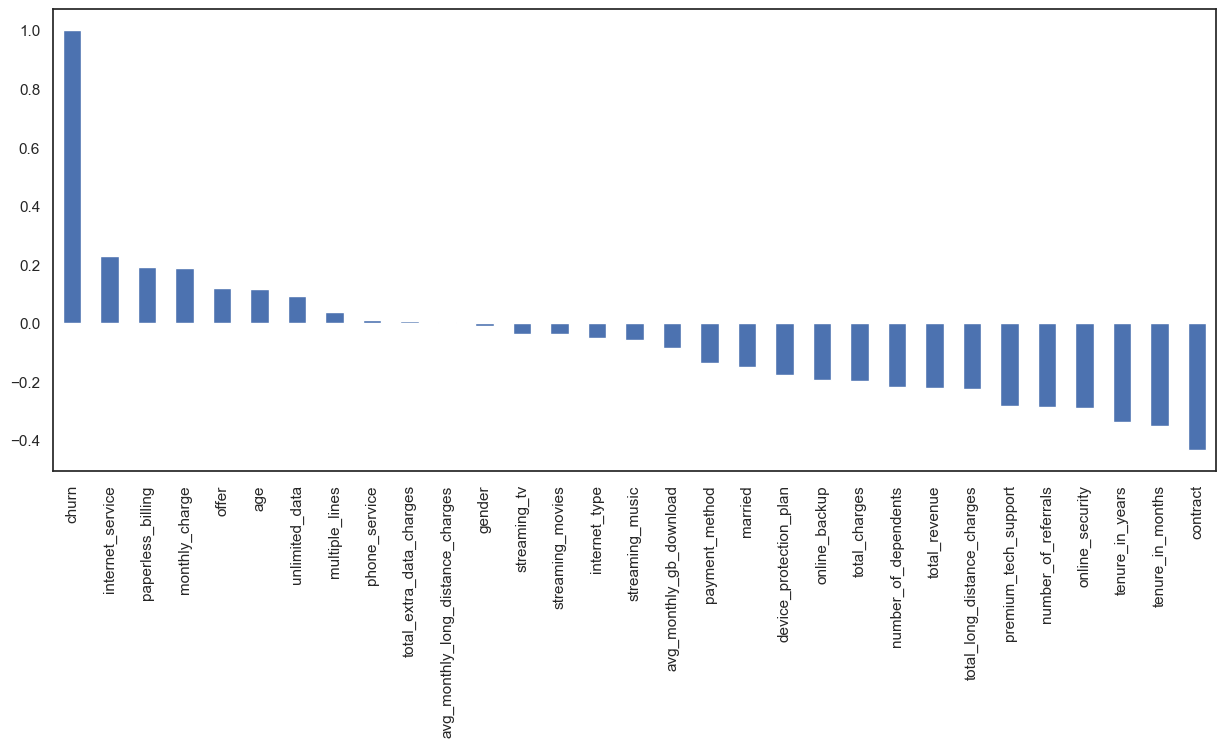

In [36]:
plt.figure(figsize=(15,6))
raw['churn'].sort_values(ascending = False).plot(kind='bar')

In [37]:
# 데이터프레임 csv로 저장
df.to_csv('모델링시작.csv', index=False)

이탈 고객 데이터가 충성 고객 데이터에 비해 너무 적어 불균형 데이터이므로 언더샘플링을 함

언더샘플링 : 충성고객 데이터가 회원 당 여러개가 아니라 딱 1개의 데이터만 남을 수 있도록 하는 것

데이터를 랜덤하게 섞은 후 중복을 제거


추가로 검증방법은 k-fold 교차 검증 방식이 많이 이용되고 있음

In [38]:
# test_size : 테스트 셋 구성의 비율
# 0.2는 전체 데이터 셋의 20%를 test셋으로 지정하겠다는 의미
# shuffle : default = True  split을 해주기 이전에 섞을 건지 여부
# stratify : classfication을 다룰 때 매우 중요한 옵션값
# 한쪽에 쏠려서 분배되는 것을 방지
# random_state : 세트를 섞을 때 해당 int값을 보고 섞으며 하이퍼 파라미터를 튜닝시 이 값을 고정해두고
# 튜닝해야 매번 데이터 셋이 변경되는 것을 방지할 수 있음